# Clear sky detection...
... using the Bright-Sun (2020) algorithm from [GitHub](https://github.com/JamieMBright/csd-library)

This algorithm requires an clear sky first guess. Here, the [python-pvlib](https://pvlib-python.readthedocs.io/en/stable/) package is used to do this, so its required to run this example. Alternatively a clear sky model from could be selected from [GitTea](https://gitea.tropos.de/walther/clear_sky_models), which may require additional data (e.g. albedo, aerosol, ozone...). But there are also clear sky models expecting nothing more than sza and date (e.g. ashrae) which also work fine, since the Bright-Sun algorithm optimizes these first guess values.
Regardless, the pvlib and the clear sky model approach have quite special python requirements -> check the environment.yml files.

Examples of both approaches are shown below:

In [4]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


import csd_bright_sun_2020 as bscsd
csds = bscsd.bright_sun_csds # sun disk is free of clouds
csdc = bscsd.bright_sun_csdc # entire sky is assumed cloud free

/home/walther/.conda/envs/pp3/lib/python3.7/site-packages/xarray/core/common.py:1124: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset


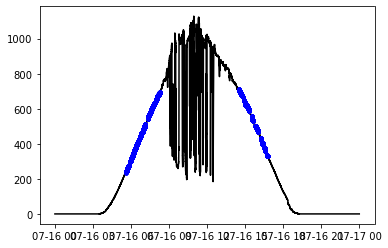

In [5]:
### pvlib ###
# conda env create -f environment_pvlib.yml
def get_clearsky_pvlib(RAD):
    from pvlib import clearsky
    from pvlib.location import Location
    #setup location
    loc = Location(RAD.latitude,
                   RAD.longitude,
                   'UTC',700)
    # resample to 1 min resolution (required for clear sky detection)
    # also skip if sun is below horizon
    rRAD = RAD.where(RAD.szen<90,drop=True).resample(time='1MIN').mean()

    # calculate clear sky irradiance
    times = pd.to_datetime(rRAD.time.values)
    rRADcs = xr.Dataset(loc.get_clearsky(times)).rename({'dim_0':'time'})
    
    # detect clear sky
    CSD = csdc(rRAD.time,
               rRAD.szen,
               rRAD.GHI,
               rRADcs.ghi,
               rRAD.DHI,
               rRADcs.dhi,
               RAD.longitude)
    csd = xr.DataArray(CSD[1].data*~CSD[1].mask,coords={'time':rRAD.time},dims=['time'])
    
    # reindex to original time resolution
    csd = csd.reindex_like(RAD.time,
                           method='nearest',
                           tolerance=np.timedelta64(1,'m'),
                           fill_value=False)
    return csd



pf = "/vols/satellite/home/jonas/data/mordor/2018_2019_metpvnet/ncdata"
fname = os.path.join(pf,"{date:%Y/%m/%Y-%m-%d}_{table}.nc")

date = dt.date(2019,7,16)
RAD = xr.open_dataset(fname.format(date=date,table='Radiation'))
    
CSD = get_clearsky_pvlib(RAD)       
plt.plot(RAD.time,RAD.GHI,'k')
plt.plot(RAD.time[CSD],RAD.GHI[CSD],'b.')
plt.xlabel('time [UTC]')
plt.ylabel('irradiance [Wm-2]')
plt.grid(True)



/home/walther/.conda/envs/pp3/lib/python3.7/site-packages/xarray/core/common.py:1124: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset


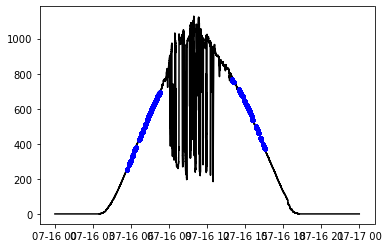

In [22]:
### clear sky model ###
# git clone https://gitea.tropos.de/walther/clear_sky_models
# conda env create -f environment_csm.yml

def get_clearsky_csm(RAD):
    import clear_sky_models.models as csm

    # resample to 1 min resolution (required for clear sky detection)
    # also skip if sun is below horizon
    rRAD = RAD.where(RAD.szen<90,drop=True).resample(time='1MIN').mean()

    # calculate clear sky irradiance
    times = pd.to_datetime(rRAD.time.values)
    dni,dhi,ghi = csm.model_06_ashrae(date=np.datetime64(date),sza=rRAD.szen)
    
    # detect clear sky
    CSD = csdc(rRAD.time,
               rRAD.szen,
               rRAD.GHI,
               ghi,
               rRAD.DHI,
               dhi,
               RAD.longitude)
    csd = xr.DataArray(CSD[1].data*~CSD[1].mask,coords={'time':rRAD.time},dims=['time'])
    
    # reindex to original time resolution
    csd = csd.reindex_like(RAD.time,
                           method='nearest',
                           tolerance=np.timedelta64(1,'m'),
                           fill_value=False)
    return csd



pf = "/vols/satellite/home/jonas/data/mordor/2018_2019_metpvnet/ncdata"
fname = os.path.join(pf,"{date:%Y/%m/%Y-%m-%d}_{table}.nc")

date = dt.date(2019,7,16)
RAD = xr.open_dataset(fname.format(date=date,table='Radiation'))
    
CSD = get_clearsky_csm(RAD)       
plt.plot(RAD.time,RAD.GHI,'k')
plt.plot(RAD.time[CSD],RAD.GHI[CSD],'b.')
plt.xlabel('time [UTC]')
plt.ylabel('irradiance [Wm-2]')
plt.grid(True)
